# Hauptkomponentenanalyse vs. 
# Denoising Variational Autoencoders

## _Intuition, Formalismus und Beispiele_

jupyter nbconvert PCAvsDVAE.ipynb --to slides --post serve

jupyter-nbextension install rise --py --sys-prefix
jupyter-nbextension enable rise --py --sys-prefix

# Eine intuitive Perspektive ...

#### "... realistische, hochdimensionale Daten konzentrieren sich in der Nähe einer nichtlinearen, niedrigdimensionalen Mannigfaltigkeit ..." [Lei et al., 2018]

![](manifold.png)

#### Aber wie lernt man die Mannigfaltigkeit und die Wahrscheinlichkeitsverteilung darauf?

![](manifold-generic.png)

# Evaluating PCA and DVAE through examples

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

![](mnist.png)


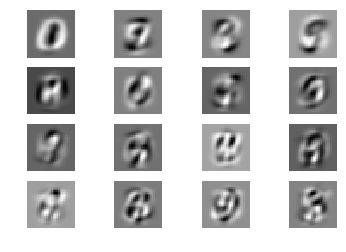

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras import regularizers, models, optimizers
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Analytical PCA of the training set
def AnalyticalPCA(y, dimension):
    pca = PCA(n_components=dimension)
    pca.fit(y)
    loadings = pca.components_
    return loadings

def PlotResults(p,dimension,name):
    sqrt_dimension = int(np.ceil(np.sqrt(dimension)))
    plt.figure()
    for i in range(p.shape[0]):
        plt.subplot(sqrt_dimension, sqrt_dimension, i + 1)
        plt.imshow(p[i, :, :],cmap='gray')
        plt.axis('off')
    plt.savefig(name + '.png')

dimension = 16                                                                  # feel free to change this, but you may have to tune hyperparameters
(y, _), (_, _) = mnist.load_data()                                              # load MNIST training images
shape_y = y.shape                                                               # store shape of y before reshaping it
y = np.reshape(y,[shape_y[0],shape_y[1]*shape_y[2]]).astype('float32')/255      # reshape y to be a 2D matrix of the dataset
p_analytical = AnalyticalPCA(y,dimension)                                       # PCA by applying SVD to y
p_analytical = np.reshape(p_analytical,[dimension,shape_y[1],shape_y[2]])       # reshape loading vectors before plotting
PlotResults(p_analytical,dimension,'AnalyticalPCA')

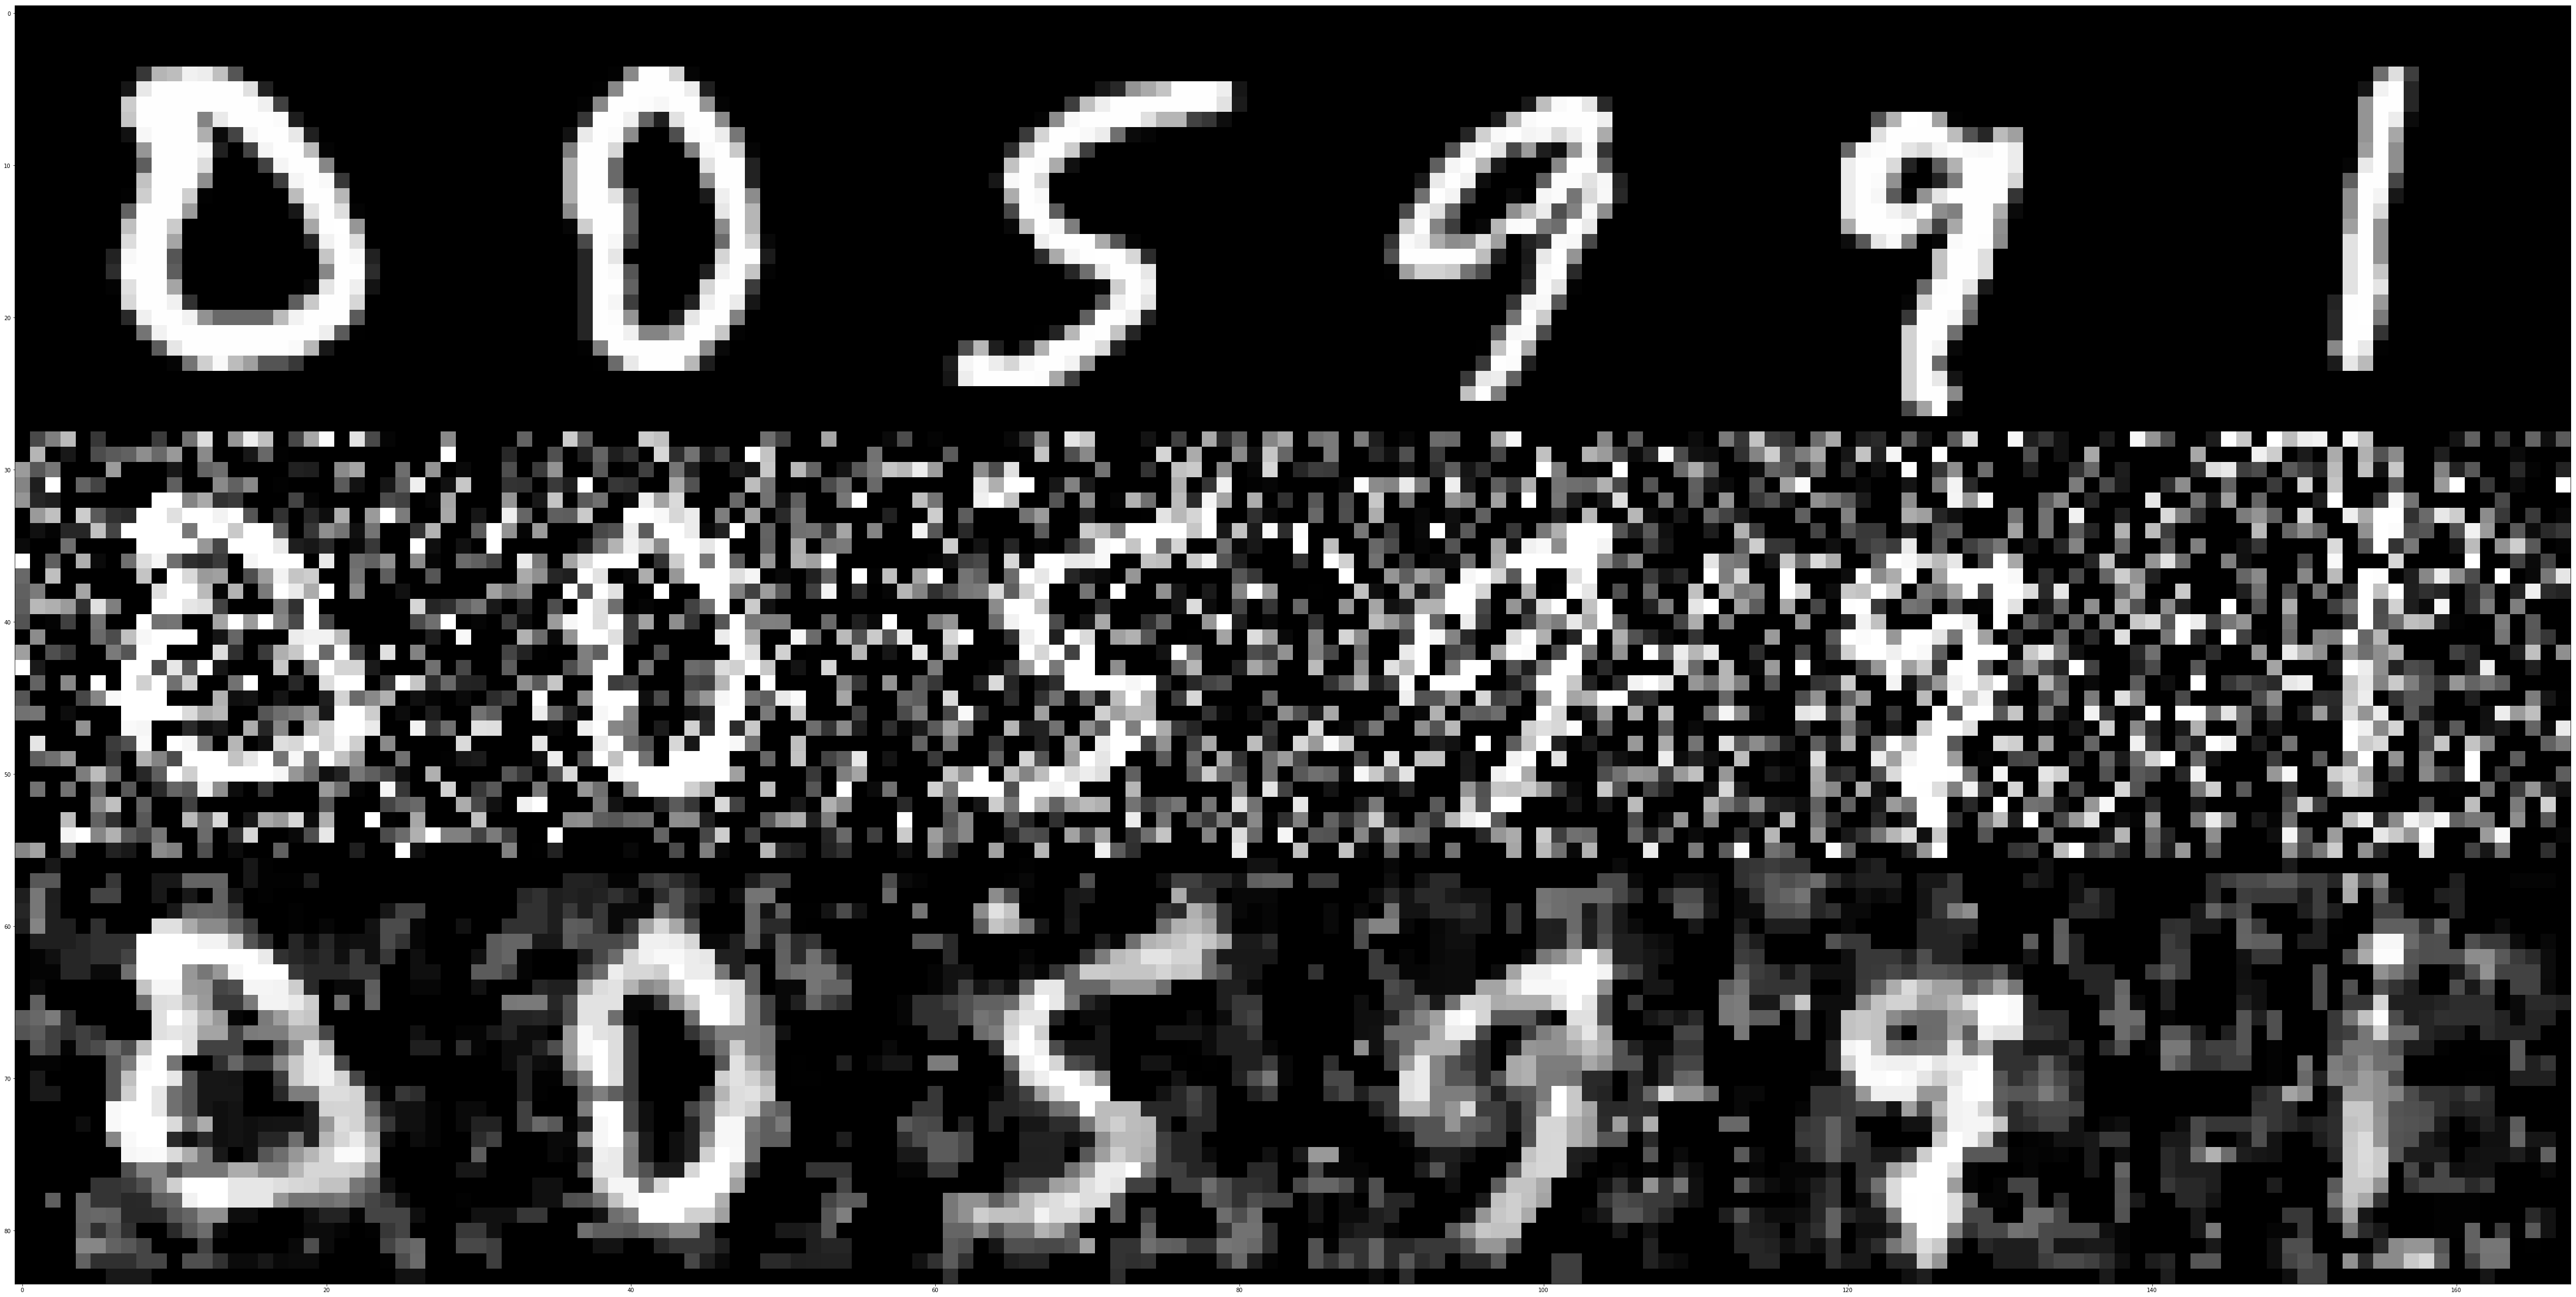

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 26, 26, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 24, 24, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

In [ ]:
# https://github.com/block98k/Denoise-VAE/blob/master/Denoise-VAE-keras.ipynb

from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

%matplotlib inline

batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 10
epsilon_std = 1.0
noise_factor = 0.5

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_num=50000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

num_train = 50000
n_images = 6
import scipy.signal as signal
figure = np.zeros((28*3 , 28 * n_images))
# Display
showidx=np.random.randint(0,num_train,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
    # replace median filter with PCA 
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_train[idx], [28, 28]),[3,3])
plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)
h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)
vae.summary()

from keras.utils.vis_utils import plot_model
plot_model(vae, to_file='model1.png',show_shapes=True)


# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss
vae.compile(optimizer='adam', loss=VAE_loss)

vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

digit_size = 28
figure = np.zeros((digit_size * 4, digit_size * n_images))


num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test[showidx])
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_keras_VAE.png')
plt.show()

In [ ]:
# https://github.com/dojoteef/dvae

# Hauptkomponentenanalyse 
# (Principal Component Analysis, PCA)
* __unsupervised__ learning
* __linear transformation__ 
    * "encode" a set of observations to a new coordinate system in which the values of the first coordinate (component) have the largest possible variance [Friedman et al., 2017]
    * the resulting coordinates (components) are uncorrelated with the preceeding coordinates
* practically computing
    * __eigendecomposition of the covariance matrix__
    * __singular value decomposition__ of the observations
* used for __dimensionality reduction__
* __reconstructions of the observations__("decoding") from the leading __principal components__ have the __least total squared error__

## Grundlegende Mathematik der PCA

### Lineare Transformation

* Let $\{y_i\}^N_{i=1}$ be a set of $N$ observations vectors, each of size $n$, with $n\leq N$. 

* A __linear transformation__ on a finite dimensional vector can be expressed as a __matrix multiplication__: 

$$ \begin{align} x_i = W y_i \end{align} $$  
  
where $y_i \in R^{n}, x_i \in R^{m}$ and $W \in R^{nxm}$. 

* Each $j-th$ element in $x_i$ is the __inner product__ between $y_i$ and the $j-th$ column in $W$, denoted as $w_j$. Let $Y \in R^{nxN}$ be a matrix obtained by horizontally concatenating $\{y_i\}^N_{i=1}$, 

$$ Y = \begin{bmatrix} | ... | \\ y_1 ... y_N \\ | ... | \end{bmatrix} $$

* Given the __linear transformation__, it is clear that:

$$ X = W^TY,  X_0 = W^TY_0, $$

where $Y_0$ is the matrix of centered (i.e. subtract the mean from each each observation).

### Maximale Varianzkomponenten, Kovarianz und Dekorrelation
* In particular, when $W^T$ represents the __transformation applying Principal Component Analysis__, we denote $W = P$. Each column of $P$, denoted $\{p_j\}^n_{j=1}$ is a __loading vector__, whereas each transformed vector $\{x_i\}^N_{i=1}$ is a __principal component__.

![](pca-intuition.png)

* The first loading vector is the unit vector with which the inner products of the observations have the __greatest variance__:

$$ \max w_1^T Y_0Y_0^Tw_1, w_1^Tw_1 = 1$$

* The solution of the previous equation is the first eigenvector of the __sample covariance matrix__ $Y_0Y_0^T$ corresponding to the largest eigenvalue.

* MAtrix $P$ can be calculated by diagonalizing the covariance matrix:

$$ Y_0Y_0^T = P \Lambda P^{-1} = P \Lambda P^T $$

$\Lambda = Y_0Y_0^T $ is a diagnoal matrix whose diagonal elements $\{\lambda_i\}^N_{i=1}$ are sorted descendingly. The inverse transformation is $ Y = PX $. Due to the fact that the covariance matrix of $X$ is diagonal PCA is a __decorrelation transformation__.

### Dimensionsreduzierung, Komprimierung, Skalierung
PCA is used for __dimensionality reduction__ due to its capability to __reduce the number of variables__ through a linear transformation. This is done by keeping the first $m$ principal components $(m < n)$ and applying:

$$ X_m = P_m^TY$$

Keeping only the $m$ principal components, PCA __loses information__ (i.e. __lossy compression__), but the __loss is minimized__ by __maximizing the components variances__.

Many __iterative algorithms__ can be used for finding the $m$ largest eigenvalues of $Y_0Y_0^T$
* QR algorithm
* Jacobi algorithm
* power method

For __large datasets__ such algorithms are __prohibitive__.

### Minimaler quadratischer Gesamtrekonstruktionsfehler

The transformation matrix $P_m$ can be also computed as a solution of:

$$ \min_{W \in R^{nxm}} \| Y_0 - WW^TY_0 \|_F^2, W^TW = I_{mxm}$$

where $F$ is the Frobenius norm. 

This shows that $P_m$ __compresses each centered vector__ of length $n$ into a vector of length $m$ where ($ m < n$) such that it __minimizes__ the sum of total __squared reconstruction errors__ (i.e. __inverse transformation__). 

### Singularwert-Zerlegung (Singular Value Decomposition, SVD)

The matrix $Y_0 \in R^{nxN}$ can be __factorized__ as $Y_0 = U \Sigma V^T$ where $U \in R^{nxn}$ and $V \in R^{NxN}$ are __orthogonal matrices__ and $\Sigma \in R^{nxN}$ has non-zero elements only on the diagonal (i.e. __singular values__).

The SVD of $Y_0$ is equivalent to the __eigendecomposition__ of $Y_0T_0^T$. 

![](svd-graphic.png)

A (non-zero) vector v of dimension N is an __eigenvector__ of a square N × N matrix A if it satisfies the __linear equation__

$$Av =\lambda v$$

where $λ$ is a scalar, termed the __eigenvalue corresponding to v__.

# Autoencoders
* unsupervised neural network
* minimize the error of reconstructions of observations [Goodfellow et al., 2016]
* basically responsible to learn the identity function
* training with backpropagation and then separate to implement the encoding / deconding

A typical __autoencoder pipeline__ looks as

![](autoencoder-pipeline.png)

## Grundlegende Mathematik der Autoencoders

For each input vector $x$ of dimension $d$ out of the entire dataset of size $n$, the network tries to reconstruct $x'$, by:
* first encoding the input (i.e. applying linear / nonlinear transformation $g_\phi(.)$)
* obtaining a latent, compressed code in the bottleneck layer, $z$, and
* decoding the compressed input at the output using linear / nonlinear transformation $f_\theta(.)$

The parameters $(\theta, \phi)$ are learned together to output a reconstructed data sample similar to the input, $x \approx f_\theta(g_\phi(x))$, in other words the identity function.

There are multiple metrics to quantify the difference, cross-entropy when activation function is sigmoid, or the simple Mean Squared Error (MSE):

$$ \frac{1}{n} \sum_{i=1}^{n}(x^{i} - f_\theta(g_\phi(x^{i}))^2$$

![](autoencoder.png)

# PCA vs. Autoencoders

*  an autoencoder with a single fully-connected hidden layer, a linear activation function and a squared error cost function is closely related to PCA - its weights span the principal subspace [Plaut, 2018]
* in autoencoders the diagonal approximation in the encoder together with the inherent stochasticity force local orthogonality of the decoder
* in autoencoders local behavior of promoting both reconstruction and orthogonality matches closely how the PCA embedding is chosen [Rolinek et al, 2019]
* the difference is that, opposite from PCA, in Autoencoders the coordinates of the output of the bottleneck are correlated and are not sorted in the descending order of variance!

# Denoising Variational Autoencoders (DVAE)

The operation process is __different__ from the basic autoencoder due to the fact that there is __noise__ injected in the input (with a certain probability distribution) and there __latent space__ needs to recover this probability to __reconstruct__ the original input [Im, Bengio et al., 2017, Kingma et al., 2017].

For each corrupted input vector $\tilde x$ of a clean vector $x$ of dimension $d$, the network tries to reconstruct $x'$, by:
* first encoding the input, representing the mapping as the probability of estimating $z$ given the input, knowing the parameters of the noise ($\mu$ and $\sigma$) to allow tractability of the posterior calculation
* obtaining a latent, compressed code in the bottleneck layer, $z$, sampled from $q_\phi(z|x)$
* decoding the compressed input at the output given the observation model $p_\theta(x|z)$

![](denoising-variational-autoencoder.png)

## Grundlegende Mathematik der DVAE

The loss function to recover the original input (__not the corrupted one__), $\tilde{x}^{i} = M(\tilde{x}^{i} | x^{i})$, if we use the simple Mean Squared Error (MSE):

$$ \frac{1}{n} \sum_{i=1}^{n}(x^{i} - f_\theta(g_\phi({\tilde{x}}^{i}))^2$$

The expectation term in the loss function invokes generating samples from $z \backsim q_\phi(z|x)$. Sampling is a stochastic process and therefore we cannot backpropagate the gradient.

The estimated posterior $q_\phi(z|x)$ should be very close to the real one $p_\theta(z|x)$. We can use Kullback-Leibler divergence to quantify the distance between these two distributions. KL divergence DKL(X∥Y) measures how much information is lost if the distribution Y is used to represent X.

Yet, Variational Bayesian methods, the loss function is known as the variational lower bound, or evidence lower bound (ELBO). The “lower bound” part in the name comes from the fact that KL divergence is always non-negative and thus the loss is the lower bound of $log p_\theta(x)$.

$$ log p_\theta(x) - D_{KL}(q_\phi(z|x) || p_\theta(z|x)) \leq log p_\theta(x) $$

Therefore by minimizing the loss, we are maximizing the lower bound of the probability of generating real data samples.

https://github.com/dojoteef/dvae

https://github.com/block98k/Denoise-VAE

# Overall comparison PCA vs. DVAE

### Manifold learning

| __PCA__ | __DVAE__ |
|-----|------|
| linear encoding/decoding, withoug noise robustness |nonlinear, probabilistic encoding/decoding with (input / hidden layer) noise robustness and nonlinear activation functions|
| decorrelated coordinates of the latent space (whitening transformation) | correlated outputs of bottleneck (decoding input) |
| coordinates of the latent space are in descending order of variance | coordinates are not sorted |
| columns of transformation matrix are orthonormal | columns of transformation matrix not necessarily orthonormal |
| robust on moderate noise with known distributions | robust to various types (masking noise, Gaussian noise, salt-and-pepper noise) and quantities of stochastic injected noise (denoising important for generalization performance) |
| basic algorithm (without regularization) low robustness | points in low-dimensional manifold robust to noise in the high-dimensional observation space |

# Overall comparison PCA vs. DVAE

### Training 

| __PCA__ | __DVAE__ |
|-----|------|
| map input to a fixed vector | map input to a distribution |
| iterative methods: QR decomposition, Jacobi algorithm, SVD | backpropagation  |
| inefficient on large datasets due to covariance calculation | efficient on large datasets due to strong manifold learning |
| based on correlation/covariance matrix, which can be - at least in theory - very sensitive to outliers | can sample directly from the input space and describe the input noise properties ("reparametrization trick") |

# References and further reading
[Goodfellow et al., 2016] Ian Goodfellow, Yoshua Bengio and Aaron Courville, Deep Learning, MIT Press, 2016.

[Friedman et al., 2017] Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie, The Elements of Statistical Learning: Data Mining, Inference, and Prediction, Springer, 2017.

[Plaut, 2018] Plaut, E., 2018. From principal subspaces to principal components with linear autoencoders. arXiv preprint arXiv:1804.10253.

[Im, Bengio et al., 2017] Im, D.I.J., Ahn, S., Memisevic, R. and Bengio, Y., 2017, February. Denoising criterion for variational auto-encoding framework. In Thirty-First AAAI Conference on Artificial Intelligence.

[Rolinek et al, 2019] Rolinek, M., Zietlow, D. and Martius, G., 2019. Variational Autoencoders Pursue PCA Directions (by Accident). In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 12406-12415).

[Lei et al., 2018] Lei, N., Luo, Z., Yau, S.T. and Gu, D.X., 2018. Geometric understanding of deep learning. arXiv preprint arXiv:1805.10451.

[Kingma et al., 2013] Kingma, D.P. and Welling, M., 2013. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.